In [1]:
# All imports

# General
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow.keras

# For CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For handling Images
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded 
                           )
import glob
import seaborn as sns
import keras

# Tensorflow
import tensorflow as tf
# AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.3.0'

### Functions

In [2]:
def load_file(filename):
    return pd.read_csv("Data/" + filename)

In [3]:
# augmenting training images

def augment_images(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image)

    return augmented['image']

In [4]:
# generating images, normalising and resizing images as well

def generate_data(data):
    
    x = []
    for i in range(len(data)):
        im = Image.open(data.iloc[i,0])
        im = im.resize((144,144))               
        im = np.array(im)
        im = im.astype('float32')
        im = im/255.0                
        x.append(im)
    x_train = np.array(x)
    
    return x_train

In [5]:
# Label Binarizer for Y label

def label_binarizer(y_train, y_test):
    le = LabelBinarizer()
    le.fit(y_train)
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.fit_transform(y_test)
    return pd.DataFrame(y_train_enc), pd.DataFrame(y_test_enc)

In [6]:
def label_encoding(y):
    le = LabelEncoder()
    y = le.fit_transform(y)  
    return y, le

In [7]:
# unzipping files

# import zipfile
# with zipfile.ZipFile('./m_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

### Cleaning and Handling Data

In [8]:
# loading training data

df = load_file("train_data.csv")

In [9]:
# renaming column

df = df.rename(columns={'filename': 'filepath'})
# df1 = df1.rename(columns={'filename': 'filepath'})

In [10]:
# adding path 

df.filepath = 'face_data/'+ df.filepath
# df1.filepath = 'Data/face_data/'+ df1.filepath

In [11]:
# removing unnessary columns

df.drop(['person_id', 'series'], axis=1, inplace=True)
# df1.drop(['person_id', 'series'], axis=1, inplace=True)

In [12]:
trainData, valData = train_test_split(df,test_size=0.20,  random_state=42)

In [13]:
# augmenting only training images 

for index, row in trainData.iterrows():
    im = cv2.imread(row['filepath'])
    for i in range(5):
        light = A.Compose([
            A.RandomBrightnessContrast(p=0.5),
            A.RGBShift(p=0.5),
            A.RandomGamma(p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=0.5),
            A.CLAHE(p=0.5),    
        ], p=1)
        
        augmented = augment_images(light, im)
        f = 'face_data/' + str(i) + row['filepath'].split('/')[-1]
        cv2.imwrite('face_data/' + str(i) + row['filepath'].split('/')[-1], augmented)
        trainData = trainData.append({'filepath' : f, 'tilt' : row['tilt'], 'pan' : row['pan'] }, ignore_index=True)

In [14]:
print(trainData.shape)
print(valData.shape)

(11160, 3)
(465, 3)


In [15]:
# generating xdata 

x_train =  generate_data(trainData)
x_val =  generate_data(valData)

In [16]:
# generating ydata

y_train = trainData.iloc[:,1:]
y_val = valData.iloc[:,1:]

In [17]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(11160, 144, 144, 3)
(465, 144, 144, 3)
(11160, 2)
(465, 2)


### Label encode

In [18]:
# Label encoding our categorical target variables to numerical form

y_tilt_train, le_tilt = label_encoding(y_train['tilt'])
y_tilt_val = le_tilt.transform(y_val['tilt'])
y_pan_train, le_pan = label_encoding(y_train['pan'])
y_pan_val = le_pan.transform(y_val['pan'])

In [19]:
y_tilt_train = keras.utils.to_categorical(y_tilt_train, len(le_tilt.classes_))
y_pan_train = keras.utils.to_categorical(y_pan_train, len(le_pan.classes_))
y_tilt_val = keras.utils.to_categorical(y_tilt_val, len(le_tilt.classes_))
y_pan_val = keras.utils.to_categorical(y_pan_val, len(le_pan.classes_))

In [20]:
y_train = [np.array(y_tilt_train), np.array(y_pan_train)]
y_val = [np.array(y_tilt_val), np.array(y_pan_val)]

### Model creation

In [21]:
# Branching CNN

# Model 2

inputs = Input(shape=x_train[0].shape)
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(1, 1))(x)

tiltBranch = Flatten()(x)
tiltBranch = Dense(32, activation='relu')(tiltBranch)
tiltBranch = BatchNormalization()(tiltBranch)
tiltBranch = Dropout(0.5)(tiltBranch)
tiltModel = Dense(9, activation='sigmoid', name = 'tilt')(tiltBranch)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(1, 1))(x)

panBranch = Flatten()(x)
panBranch = Dense(32, activation='relu')(panBranch)
panBranch = BatchNormalization()(panBranch)
panBranch = Dropout(0.5)(panBranch)
panModel = Dense(13, activation='sigmoid', name = 'pan')(panBranch)

model = Model(inputs,[tiltModel, panModel], name='models')

model.compile(optimizer='adam', loss={'tilt':'binary_crossentropy', 'pan':'binary_crossentropy'},
              metrics={'tilt':'accuracy', 'pan':'accuracy'})

model.summary()

Model: "models"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 141, 141, 16) 0           batch_normalization[0][0]        
_____________________________________________________________________________________________

In [22]:
history = model.fit(x_train,y_train, batch_size = 16, epochs=20, verbose=1, validation_data=(x_val, y_val))

Epoch 1/20
698/698 [==============================] - 21s 30ms/step - loss: 0.9550 - tilt_loss: 0.4797 - pan_loss: 0.4753 - tilt_accuracy: 0.2679 - pan_accuracy: 0.1110 - val_loss: 0.7362 - val_tilt_loss: 0.4803 - val_pan_loss: 0.2559 - val_tilt_accuracy: 0.3527 - val_pan_accuracy: 0.1892
Epoch 2/20
698/698 [==============================] - 20s 28ms/step - loss: 0.5001 - tilt_loss: 0.2444 - pan_loss: 0.2557 - tilt_accuracy: 0.5546 - pan_accuracy: 0.2211 - val_loss: 0.3985 - val_tilt_loss: 0.1857 - val_pan_loss: 0.2129 - val_tilt_accuracy: 0.7441 - val_pan_accuracy: 0.3204
Epoch 3/20
698/698 [==============================] - 20s 28ms/step - loss: 0.3767 - tilt_loss: 0.1619 - pan_loss: 0.2148 - tilt_accuracy: 0.7897 - pan_accuracy: 0.3584 - val_loss: 0.4683 - val_tilt_loss: 0.2605 - val_pan_loss: 0.2079 - val_tilt_accuracy: 0.7785 - val_pan_accuracy: 0.3290
Epoch 4/20
698/698 [==============================] - 20s 28ms/step - loss: 0.3028 - tilt_loss: 0.1172 - pan_loss: 0.1856 - tilt_a

In [23]:
score = model.evaluate(x_val, y_val, verbose=1)

15/15 [==============================] - 0s 18ms/step - loss: 0.7006 - tilt_loss: 0.1593 - pan_loss: 0.5413 - tilt_accuracy: 0.8108 - pan_accuracy: 0.1935


### Results (graph)

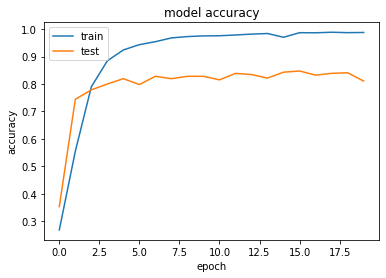

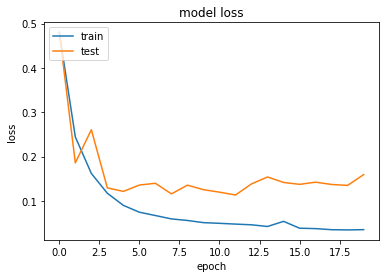

In [24]:
# summarize history for accuracy
plt.plot(history.history['tilt_accuracy'])
plt.plot(history.history['val_tilt_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['tilt_loss'])
plt.plot(history.history['val_tilt_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

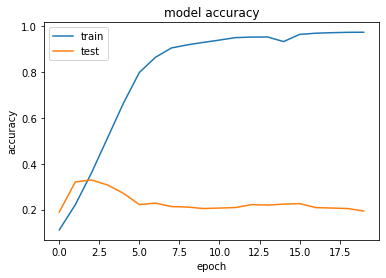

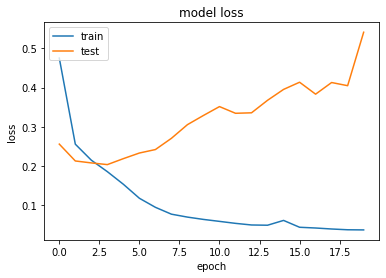

In [25]:
# summarize history for accuracy
plt.plot(history.history['pan_accuracy'])
plt.plot(history.history['val_pan_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['pan_loss'])
plt.plot(history.history['val_pan_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()